In [1]:
using LinearAlgebra
using GPFlux
using Plots; pyplot();
using Random; Random.seed!(4);
using Flux
using Zygote
using Optim
using DelimitedFiles
using Statistics
using Distributions
using Test

┌ Info: Precompiling GPFlux [4d4e40ad-7e7d-4024-a1b1-ebf43adef3b8]
└ @ Base loading.jl:1273
┌ Info: CUDAdrv.jl failed to initialize, GPU functionality unavailable (set JULIA_CUDA_SILENT or JULIA_CUDA_VERBOSE to silence or expand this message)
└ @ CUDAdrv /Users/hongbinren/.julia/packages/CUDAdrv/mCr0O/src/CUDAdrv.jl:69


In [2]:
# read CO2 data
data = readdlm("CO2_data.csv", ',')
year = data[:,1]; co2 = data[:,2];
# Split the data into training and testing data
oxtrain = year[year.<2004]; oytrain = co2[year.<2004];
oxtest = year[year.>=2004]; oytest = co2[year.>=2004];

# Xtrain = reshape(oxtrain, 1, length(oxtrain))
# Xtest = reshape(oxtest, 1, length(oxtest))
# ytrain = oytrain
# ytest = oytest;

#data preprocessing
## standardize X and y
xtrain_mean = mean(oxtrain)
ytrain_mean = mean(oytrain)
xtrain_std = std(oxtrain)
ytrain_std = std(oytrain)
xtrain = @. (oxtrain-xtrain_mean)/xtrain_std
ytrain = @. (oytrain-ytrain_mean)/ytrain_std

xtest = @. (oxtest-xtrain_mean)/xtrain_std
ytest = @. (oytest-ytrain_mean)/ytrain_std

## input data
Xtrain = reshape(xtrain, 1, length(xtrain));
Xtest = reshape(xtest, 1, length(xtest));

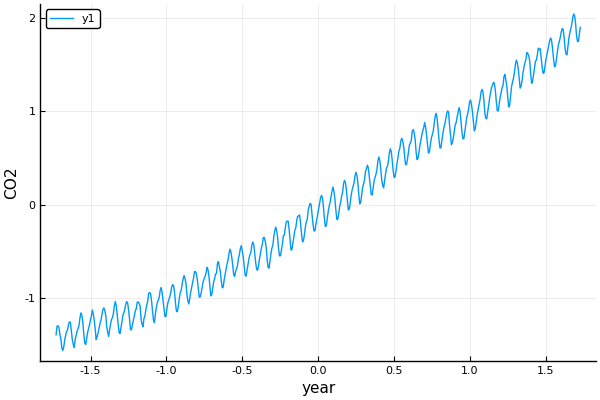

In [3]:
plot(xtrain, ytrain, xaxis=("year"), yaxis=("CO2"))

In [4]:
# kernel parameter initialization
function median_distance_local(x)
    n = length(x)
    dist = []
    for i in 1:n
        for j in i:n
            push!(dist, abs(x[j]-x[i]))
        end
    end
    median(dist)
end

l = median_distance_local(xtrain)

1.013116421583688

In [23]:
# construct kernels
iso_lin_kernel1 = IsoLinearKernel([0.0])
iso_per_kernel1 = IsoPeriodKernel([log(l)], [log(l)], [0.0])
iso_rbf_kernel1 = IsoGaussKernel([log(l/4.0)], [0.0])
iso_rq_kernel1 = IsoRQKernel([log(2.0*l)], [log(0.2)], [0.0])
iso_lin_kernel2 = IsoLinearKernel([0.0])
iso_rq_kernel2 = IsoRQKernel([log(l)], [log(0.1)], [0.0])
iso_rbf_kernel2 = IsoGaussKernel([log(l)], [0.0])
iso_per_kernel2 = IsoPeriodKernel([log(l/4.0)], [log(l/4.0)], [0.0])


# sum product network
linear1 = Linear(8, 8) |> f64
product1 = z -> GPFlux.Product(z, step=2)
linear2 = Linear(4, 4) |> f64
product2 = z -> GPFlux.Product(z, step=2)
linear3 = Linear(2, 1) |> f64

# mean function 
zero_mean = ConstantMean()

# NKN
pkernels = Primitive(iso_lin_kernel1, iso_per_kernel1, iso_rbf_kernel1, iso_rq_kernel1,
                     iso_lin_kernel2, iso_rq_kernel2, iso_rbf_kernel2, iso_per_kernel2)
nkn = NeuralKernelNetwork(pkernels, linear1, product1, linear2, product2, linear3)

NeuralKernelNetwork{Tuple{Primitive{Tuple{IsoLinearKernel{Float64,Array{Float64,1}},IsoPeriodKernel{Float64,Array{Float64,1}},IsoGaussKernel{Float64,Array{Float64,1}},IsoRQKernel{Float64,Array{Float64,1}},IsoLinearKernel{Float64,Array{Float64,1}},IsoRQKernel{Float64,Array{Float64,1}},IsoGaussKernel{Float64,Array{Float64,1}},IsoPeriodKernel{Float64,Array{Float64,1}}}},Linear{Array{Float64,2},Array{Float64,1}},var"#31#32",Linear{Array{Float64,2},Array{Float64,1}},var"#33#34",Linear{Array{Float64,2},Array{Float64,1}}}}((Primitive{Tuple{IsoLinearKernel{Float64,Array{Float64,1}},IsoPeriodKernel{Float64,Array{Float64,1}},IsoGaussKernel{Float64,Array{Float64,1}},IsoRQKernel{Float64,Array{Float64,1}},IsoLinearKernel{Float64,Array{Float64,1}},IsoRQKernel{Float64,Array{Float64,1}},IsoGaussKernel{Float64,Array{Float64,1}},IsoPeriodKernel{Float64,Array{Float64,1}}}}((IsoLinearKernel{Float64,Array{Float64,1}}([0.0]), IsoPeriodKernel{Float64,Array{Float64,1}}([0.013031146188736197], [0.0130311461887

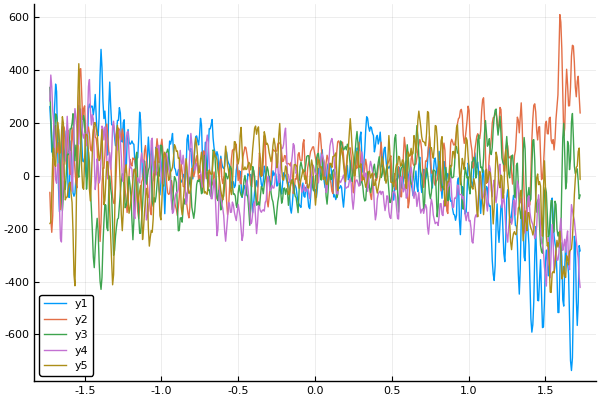

In [8]:
# sample from prior
zero_mean = ConstantMean()
gp_prior = GaussProcess(zero_mean, nkn, [-Inf])
prior_dist = MvNormal(gp_prior, Xtrain)
samples = rand(prior_dist, 5)
plot(xtrain, samples)

In [24]:
# build gp model
zero_mean = ConstantMean()
lnoise = [0.5*log(0.1)]
gp = GaussProcess(zero_mean, nkn, lnoise)
ps = GPFlux.params(gp)
negloglik(gp, Xtrain, ytrain)

2128.0005825107532

In [ ]:
function calc_g!(G, θ)
    dispatch!(gp, θ)
    ps = GPFlux.params(gp)
    gs = gradient(()->negloglik(gp, Xtrain, ytrain), ps)

    j = 1
    for p in ps
        lp = length(p)
        G[j:j+lp-1] .= vec(gs.grads[p])
        j += lp
    end
    G
end

function loss_fn(θ)
    dispatch!(gp, θ)
    negloglik(gp, Xtrain, ytrain)
end

θ = flatten_params(ps)
@show loss_fn(θ)
@show calc_g!(zeros(length(θ)), θ)
@test loss_fn(θ) ≈ negloglik(gp, Xtrain, ytrain)

In [25]:
# minimize negative loglik

using Flux.Optimise: update!

optimizer = ADAM(0.001)
loss = []
for i in 1:5000
    ll = negloglik(gp, Xtrain, ytrain)
    push!(loss, ll)
    if i==1 || i%100 == 0
        @info "step=$i, loss=$ll"
    end
    gs = gradient(()->negloglik(gp, Xtrain, ytrain), ps)
    for p in ps
        update!(optimizer, p, gs[p])
    end
end

┌ Info: step=1, loss=2128.0005825107532
└ @ Main In[25]:11
┌ Info: step=100, loss=1643.1699431428874
└ @ Main In[25]:11
┌ Info: step=200, loss=1146.4035771834965
└ @ Main In[25]:11
┌ Info: step=300, loss=665.1168328873052
└ @ Main In[25]:11
┌ Info: step=400, loss=343.67099453098297
└ @ Main In[25]:11
┌ Info: step=500, loss=97.72435955317684
└ @ Main In[25]:11
┌ Info: step=600, loss=-86.79687937497931
└ @ Main In[25]:11
┌ Info: step=700, loss=-241.04569971552678
└ @ Main In[25]:11
┌ Info: step=800, loss=-388.94920507823855
└ @ Main In[25]:11
┌ Info: step=900, loss=-521.1572555818016
└ @ Main In[25]:11
┌ Info: step=1000, loss=-635.6176823640402
└ @ Main In[25]:11
┌ Info: step=1100, loss=-730.3273095616668
└ @ Main In[25]:11
┌ Info: step=1200, loss=-805.2049149290581
└ @ Main In[25]:11
┌ Info: step=1300, loss=-864.0134627385039
└ @ Main In[25]:11
┌ Info: step=1400, loss=-913.0089308026699
└ @ Main In[25]:11
┌ Info: step=1500, loss=-960.9299455519774
└ @ Main In[25]:11
┌ Info: step=1600, l

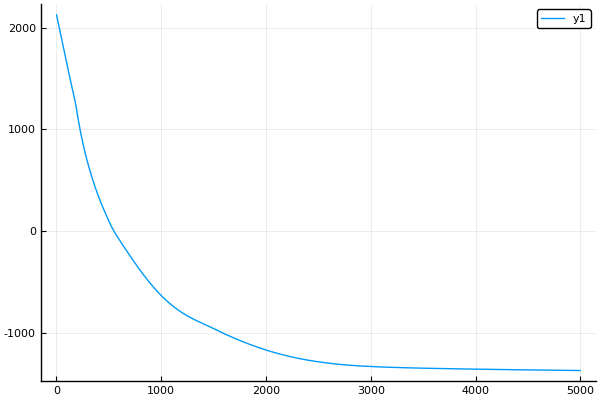

In [26]:
plot(loss)

In [27]:
pred_y, pred_σ2 = predict(gp, Xtest, Xtrain, ytrain)
pred_σ = sqrt.(pred_σ2);

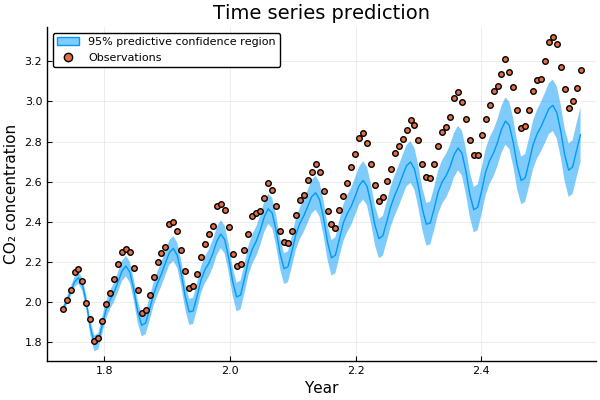

In [28]:
plot(xtest, pred_y, ribbon=pred_σ, title="Time series prediction",label="95% predictive confidence region")
scatter!(xtest, ytest, label="Observations")
plot!(xaxis=("Year"), yaxis=("CO₂ concentration"))